In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

In [2]:
import pkg_resources
import yaml
import pprint
import random
import time
import pickle
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join

# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

In [3]:
noise_keep = ["0.2", "0.4", "0.6", "0.8", "1"]
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1000' # needs to change...
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [6]:
def get_data_np(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))][:5]
    data_n = []
    for file in onlyfiles:
        data = torch.load(join(mypath,file))
        data_n.append(data)
    return data_n

In [7]:

n_bef = []
e_aft = []

for n in noise_keep:
    nn = []
    e = []
    noise_dir = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{n}/feature_store'
    data_n = get_data_np(noise_dir)
    for data in data_n:
        nb = data.x.shape[0]
        nn.append(nb)

        e_spatial = emb_eval(embed_ckpt_dir,data)

        ea = len(e_spatial[0])
        e.append(ea)
    n_bef.append(np.mean(nn))
    e_aft.append(np.mean(e))

In [8]:
n_bef

[94135.6, 97679.6, 101223.2, 104767.2, 108311.6]

In [9]:
e_aft

[8826564.2, 9684520.2, 10578277.4, 11497873.6, 12436243.8]

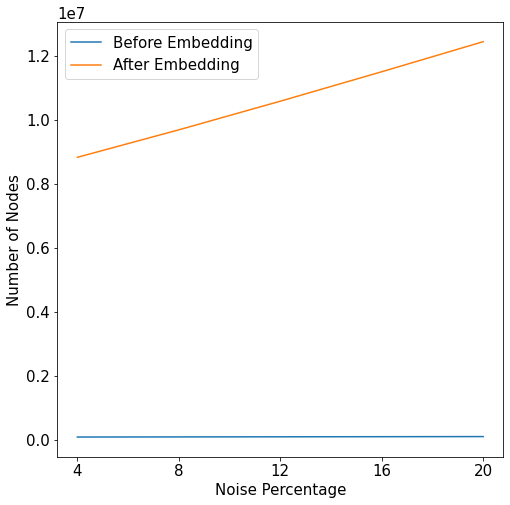

In [24]:
plt.rcParams.update({'font.size': 15, 'axes.labelsize' : 15})
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(noise_keep, n_bef,label='Before Embedding')
ax.plot(noise_keep, e_aft , label= 'After Embedding')
ax.set_xlabel('Noise Percentage')
ax.set_xticklabels([f'{float(n)*0.2*100:.0f}' for n in noise_keep])
ax.set_ylabel('Number of Nodes')
ax.legend()